In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install opencv-python                      # install opencv

In [ ]:
import cv2                                      # for image operations
import matplotlib.pyplot as plt                 # for visualisation
import numpy as np                              # for numerical operations
from google.colab.patches import cv2_imshow     # for displaying images on colab
import os
import pandas as pd
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from scipy.stats import skew, kurtosis
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from scipy.spatial import KDTree

In [ ]:
image_folder = '/content/drive/MyDrive/SPRING 2024-2025/EE417/Homeworks/takehome1/scanner_A'

In [ ]:
labeled_features_path = "/content/drive/MyDrive/SPRING 2024-2025/EE417/Homeworks/takehome1/scanner_A/labeled_features.csv"

In [ ]:
train_folder_names = ["/A01_v2","/A03_v2","/A04_v2"]

In [ ]:
test_folder_name = "/A00_v2"

In [ ]:
validation_folder_name = "/A02_v2"

In [ ]:
def plot_image(image, title="Image", cmap='gray'):
    """
    A function to plot a single image with a title.
    """
    if len(image.shape) == 3:  # Check if it's a colored image (BGR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [ ]:
def plot_side_by_side(img_1, img_2, title1="Original Image", title2="Processed Image"):
    """
    A function to plot two images side by side.
    """
    if len(img_1.shape) == 3 or len(img_2.shape) == 3:
        img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
        img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].imshow(img_1, cmap='gray')
    axs[1].imshow(img_2, cmap='gray')

    axs[0].set_title(title1)
    axs[1].set_title(title2)

In [ ]:
def plot_three_side(img_1, img_2,img_3, title1="Original Image", title2="Processed Image", title3="Predicted Image"):
    """
    A function to plot two images side by side.
    """
    if len(img_1.shape) == 3 or len(img_2.shape) == 3 or len(img_3.shape) == 3:
        img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
        img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)
        img_3 = cv2.cvtColor(img_3, cv2.COLOR_BGR2RGB)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(img_1, cmap='gray')
    axs[1].imshow(img_2, cmap='gray')
    axs[2].imshow(img_3, cmap='gray')

    axs[0].set_title(title1)
    axs[1].set_title(title2)
    axs[2].set_title(title3)

# **Stage 1) Virtualize mitosis cases**

In [ ]:
# Function to visualize mitosis points
def visualize_mitosis(image_path, csv_path):
    # Read the image
    processed_image = cv2.imread(image_path)
    processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)  # Convert to RGB for Matplotlib

    # List to store mitosis coordinates
    mitosis_points = []

    # Read the CSV file (Each row has multiple x, y pairs)
    if os.path.exists(csv_path):
        with open(csv_path, 'r') as file:
            for line in file:
                values = line.strip().split(',')  # Split by comma
                coords = list(zip(map(int, values[::2]), map(int, values[1::2])))  # Extract (x, y) pairs
                mitosis_points.extend(coords)

        # Convert list to DataFrame
        df = pd.DataFrame(mitosis_points, columns=['x', 'y'])

                # Iterate through each mitosis point and change the pixel color
        for index, row in df.iterrows():
            x, y = int(row['x']), int(row['y'])

            # Change the pixel color at (x, y) to red (BGR format for OpenCV)
            processed_image[y, x] = [0, 0, 255]  # BGR for red (OpenCV uses BGR format)
        return processed_image
    else:
        print(f"No CSV found for {image_path}")

In [ ]:
def ground_truth(image_path, csv_path):
    """
    Create a black image and directly mark mitosis pixels (x, y) from CSV as red.
    """
    image = cv2.imread(image_path)
    height, width = image.shape[:2]

    # Create a completely black image
    black_image = np.zeros((height, width, 3), dtype=np.uint8)

    mitosis_points = []

    if os.path.exists(csv_path):
        with open(csv_path, 'r') as file:
            for line in file:
                values = line.strip().split(',')
                coords = list(zip(map(int, values[::2]), map(int, values[1::2])))
                mitosis_points.extend(coords)

        # Mark each pixel in red (BGR format)
        for x, y in mitosis_points:
            if 0 <= x < width and 0 <= y < height:
                black_image[y, x] = [0, 0, 255]  # 🔴 Red pixel in BGR

        return black_image
    else:
        print(f"❌ No CSV found for {csv_path}")
        return None


In [ ]:
for subdir, _, files in os.walk(image_folder):
    # Get all BMP images
    image_files = [f for f in files if f.endswith('.bmp')]

    # Process each image
    for image_file in image_files:
        image_path = os.path.join(subdir, image_file)
        csv_path = os.path.join(subdir, os.path.splitext(image_file)[0] + '.csv')

        print(f"Processing: {image_path}")

        # Read and process the image
        image = cv2.imread(image_path)
        processed_image = image.copy()
        # List to store mitosis coordinates
        mitosis_points = []

        # Read the CSV file (Each row has multiple x, y pairs)
        if os.path.exists(csv_path):
            with open(csv_path, 'r') as file:
                for line in file:
                    values = line.strip().split(',')  # Split by comma
                    coords = list(zip(map(int, values[::2]), map(int, values[1::2])))  # Extract (x, y) pairs
                    mitosis_points.extend(coords)

            # Convert list to DataFrame
            df = pd.DataFrame(mitosis_points, columns=['x', 'y'])

            # Iterate through each mitosis point and change the pixel color
            for index, row in df.iterrows():
                x, y = int(row['x']), int(row['y'])

                # Check for boundary conditions (avoid out-of-bounds errors)
                if 0 <= x < processed_image.shape[1] and 0 <= y < processed_image.shape[0]:
                    # Change the pixel color at (x, y) to red (RGB for display)
                    processed_image[y, x] = [0, 255, 255]  # BGR for red

        else:
            print(f"No CSV found for {image_path}")

        # Plot the original and processed images side by side
        plot_side_by_side(image, processed_image)

# **Stage 2) Background seperation**


In [ ]:
def preprocess_and_segment(image_path, threshold=75):
    # Step 1: Read and convert to grayscale
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 2: Gaussian Blur to smooth out noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)


    # Step 3: Compute local mean
    #radius = 5
    kernel = np.ones((3, 3), np.uint8)
    #kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2 * radius + 1, 2 * radius + 1))
    local_mean = cv2.filter2D(blurred, -1, kernel)
    #print("LocalMean: ",local_mean)

    # Step 4: Detect darker regions
    darker_regions = np.where(blurred < (local_mean - threshold), 255, 0).astype(np.uint8)
    #plot_image(darker_regions,"DarkerReg")


    # Step 5: Detect brighter regions
    brighter_regions = np.where(blurred > (local_mean + threshold), 255, 0).astype(np.uint8)
    #plot_image(brighter_regions,"BrighterReg")

    # Step 6: Subtract brighter regions from darker regions
    final_regions = np.clip(darker_regions - brighter_regions, 0, 255).astype(np.uint8)

    # Step 5: Morphological Operations
    morph_kernel = np.ones((3, 3), np.uint8)

    # Apply opening to remove small noise
    opened = cv2.morphologyEx(final_regions, cv2.MORPH_OPEN, morph_kernel, iterations=3)

    # Apply closing to connect small gaps
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, morph_kernel, iterations=2)

    dilated = cv2.dilate(closed, morph_kernel, iterations=6)
    dilated = (dilated > 5).astype(np.uint8) * 255
    #num_labels, labels = cv2.connectedComponents(closed)
    #print("NumLabels: ",num_labels,labels)
    return dilated

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_filtered_components(processed_image, min_area=50):
    """Visualizes which connected components are kept vs. removed based on area."""

    # Get connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(processed_image)

    # Create a copy of the image for visualization
    vis_image = processed_image.copy()

    for i in range(1, num_labels):  # Ignore background (0)
        x, y, w, h, area = stats[i]

        if area > min_area:
            color = (255, 0, 0)  # RED = Kept (valid components)
        else:
            color = (0, 0, 255)  # BLUE = Removed (too small)

        cv2.rectangle(vis_image, (x, y), (x + w, y + h), color, 2)  # Draw box
        cv2.putText(vis_image, str(area), (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.imshow(vis_image)
    plt.title(f"Filtered Components (min_area={min_area})")
    plt.axis("off")
    plt.show()


/content/drive/MyDrive/SPRING 2024-2025/EE417/Homeworks/takehome1/scanner_A/A02_v2/A02_05.bmp


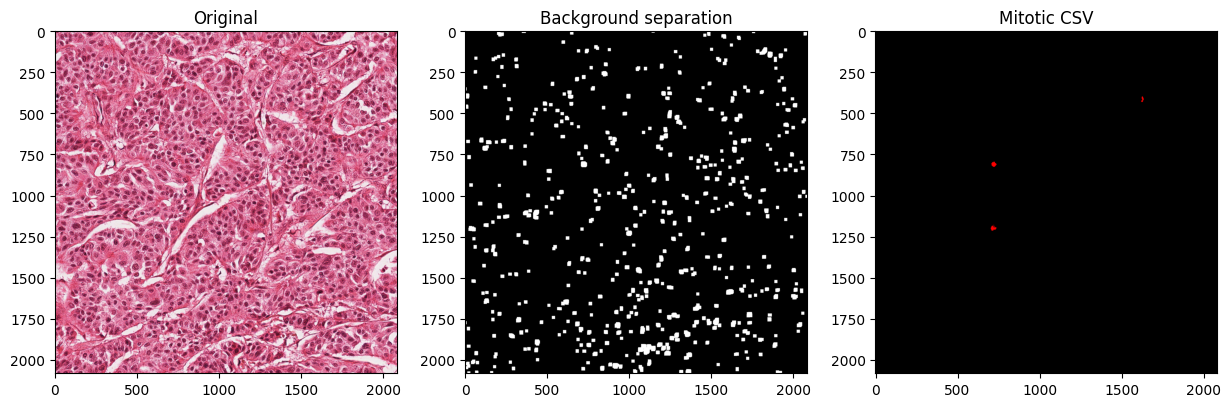

In [ ]:
test_image_path = image_folder + "/A02_v2/A02_05.bmp"
image = cv2.imread(test_image_path)
csv_path = os.path.join(subdir, os.path.splitext(test_image_path)[0] + '.csv')
print(test_image_path)


processed_image  = preprocess_and_segment(test_image_path)
visualized_mitosis = ground_truth(image_path,csv_path)

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(processed_image)

min_area = 50  # Adjust this threshold
filtered_stats = [s for s in stats if s[cv2.CC_STAT_AREA] > min_area]

#visualize_filtered_components(processed_image, min_area=50)

#print(f"Filtered Connected Components: {len(filtered_stats)}")

#print(num_labels,stats,centroids)

plot_three_side(image,processed_image,visualized_mitosis,"Original","Background separation","Mitotic CSV")


In [ ]:
for train in train_folder_names:
  for subdir, _, files in os.walk(image_folder+train):
      # Get all BMP images
      print(image_folder+train)
      image_files = [f for f in files if f.endswith('.bmp')]
      # Process each image
      for image_file in image_files:
          image_path = os.path.join(subdir, image_file)
          csv_path = os.path.join(subdir, os.path.splitext(image_file)[0] + '.csv')

          print(f"Processing: {image_path}")

          # Read and process the image
          visualized_mitosis = ground_truth(image_path,csv_path)
          image = cv2.imread(image_path)
          processed_image  = preprocess_and_segment(image_path)
          num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(processed_image)

          plot_three_side(image,processed_image,visualized_mitosis,"Original",f"Processed {num_labels}#","Mitosis Ground Truth")


📍 Image: A01_05.bmp
✅ Connected Components (excluding background): 148
⚪ Segmented Area: 98241
🔴 Ground Truth Area: 4430
🔵 Intersection Area: 3438
📏 IoU: 0.0346
📍 Image: A01_01.bmp
✅ Connected Components (excluding background): 172
⚪ Segmented Area: 103527
🔴 Ground Truth Area: 3306
🔵 Intersection Area: 3263
📏 IoU: 0.0315
📍 Image: A01_02.bmp
✅ Connected Components (excluding background): 75
⚪ Segmented Area: 39044
🔴 Ground Truth Area: 8853
🔵 Intersection Area: 4660
📏 IoU: 0.1078
📍 Image: A01_08.bmp
✅ Connected Components (excluding background): 98
⚪ Segmented Area: 53399
🔴 Ground Truth Area: 5198
🔵 Intersection Area: 2779
📏 IoU: 0.0498
📍 Image: A01_00.bmp
✅ Connected Components (excluding background): 163
⚪ Segmented Area: 100622
🔴 Ground Truth Area: 7359
🔵 Intersection Area: 7109
📏 IoU: 0.0705
📍 Image: A01_03.bmp
✅ Connected Components (excluding background): 206
⚪ Segmented Area: 112991
🔴 Ground Truth Area: 8363
🔵 Intersection Area: 6037
📏 IoU: 0.0524
📍 Image: A01_07.bmp
✅ Connected C

<ipython-input-25-884110a5c0fd>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))


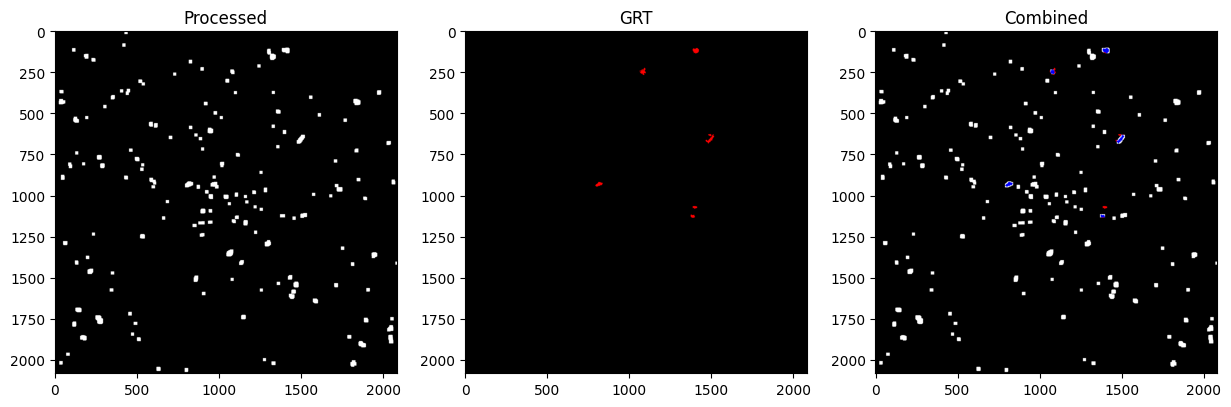

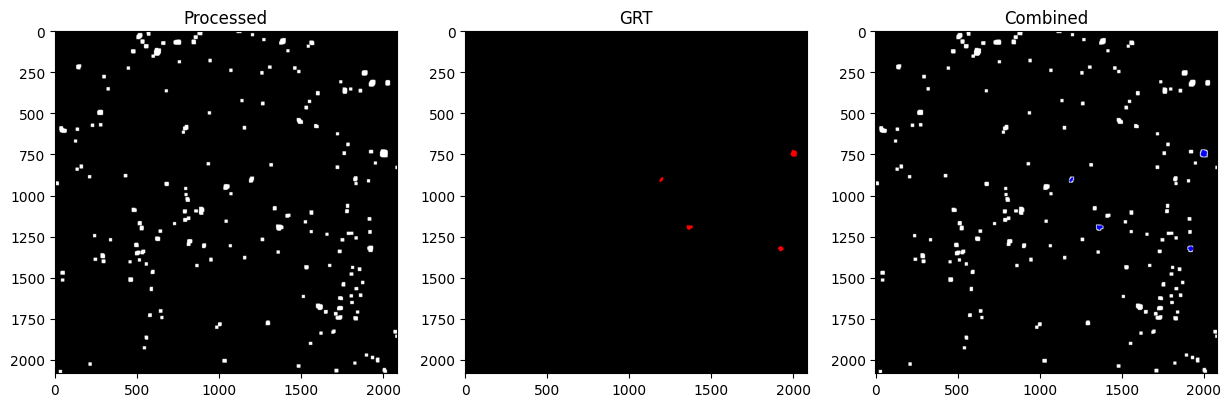

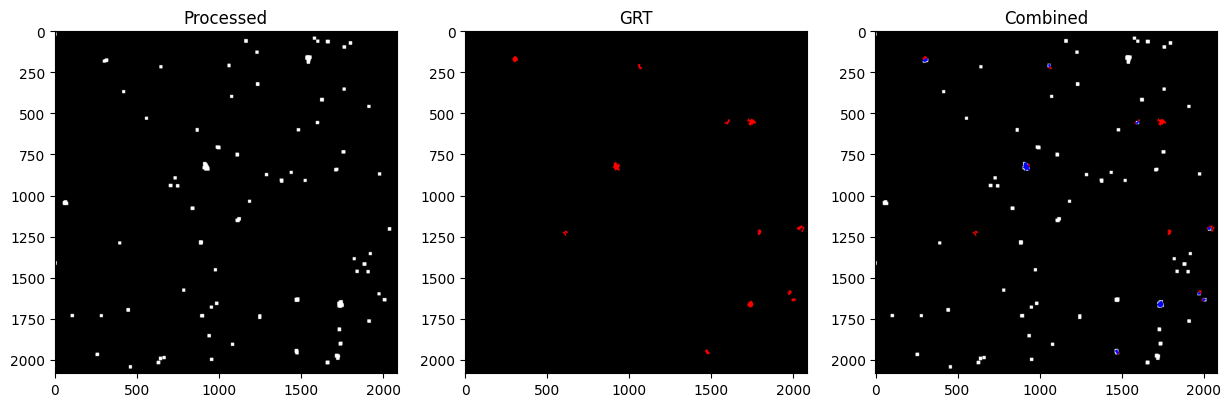

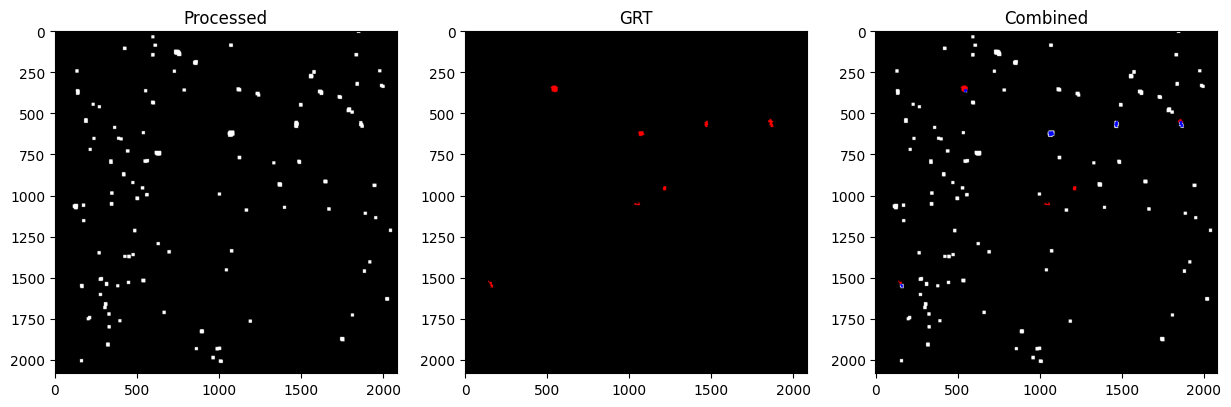

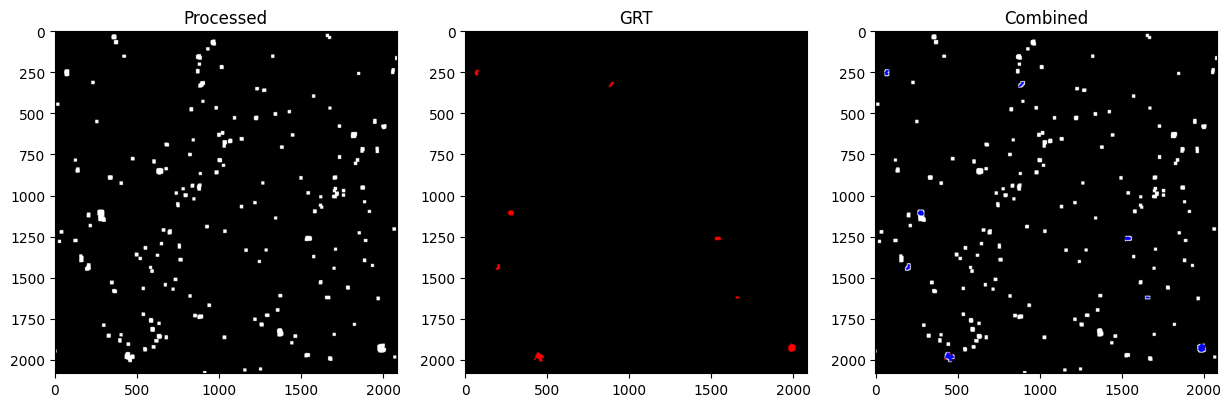

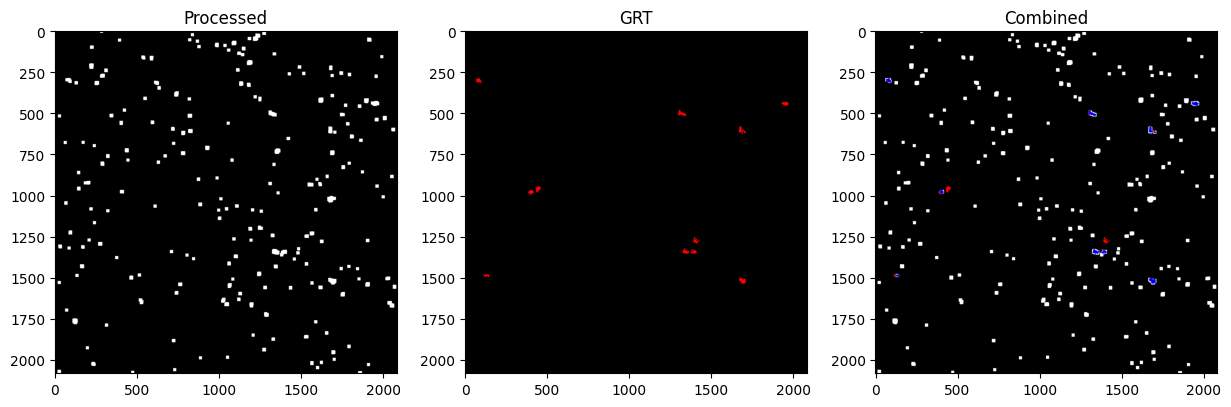

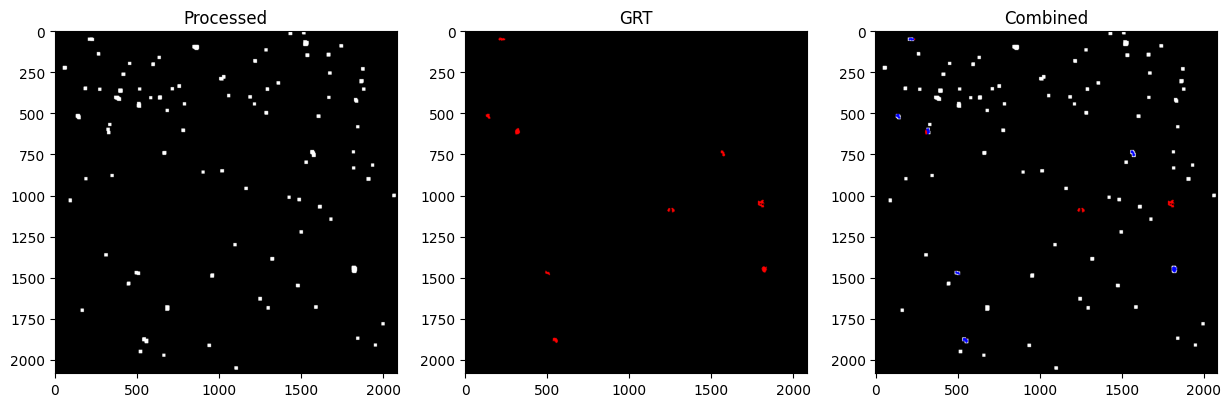

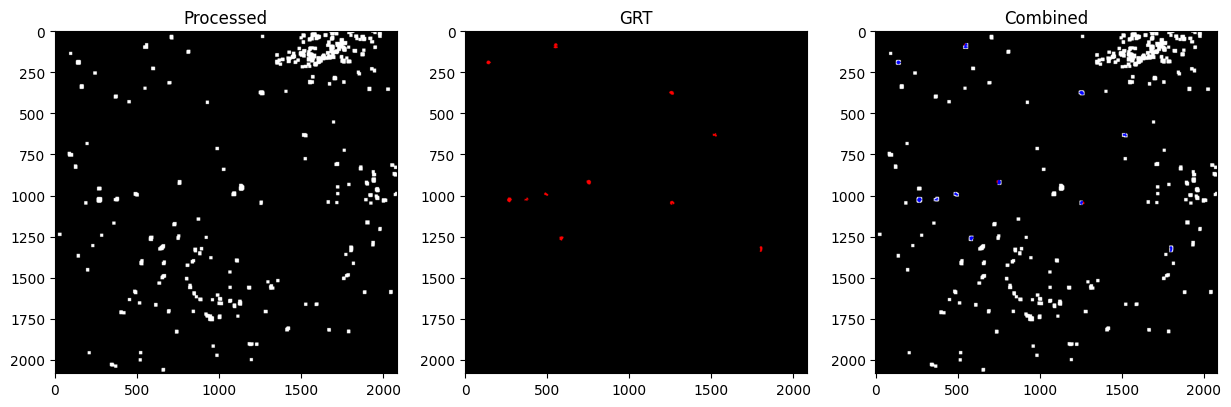

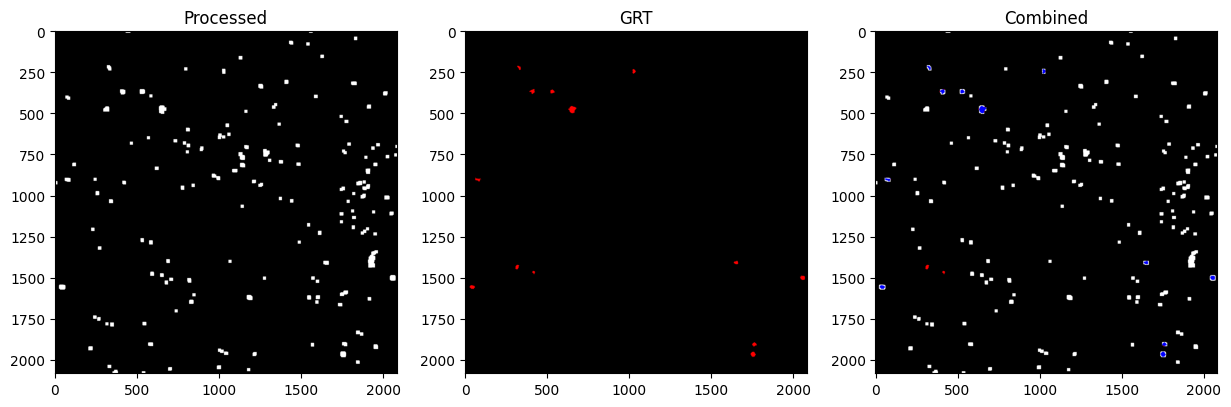

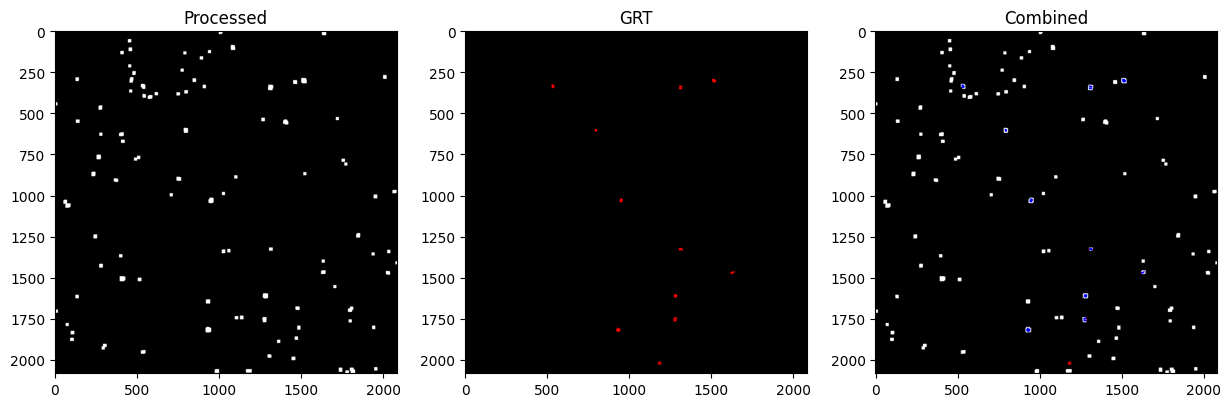

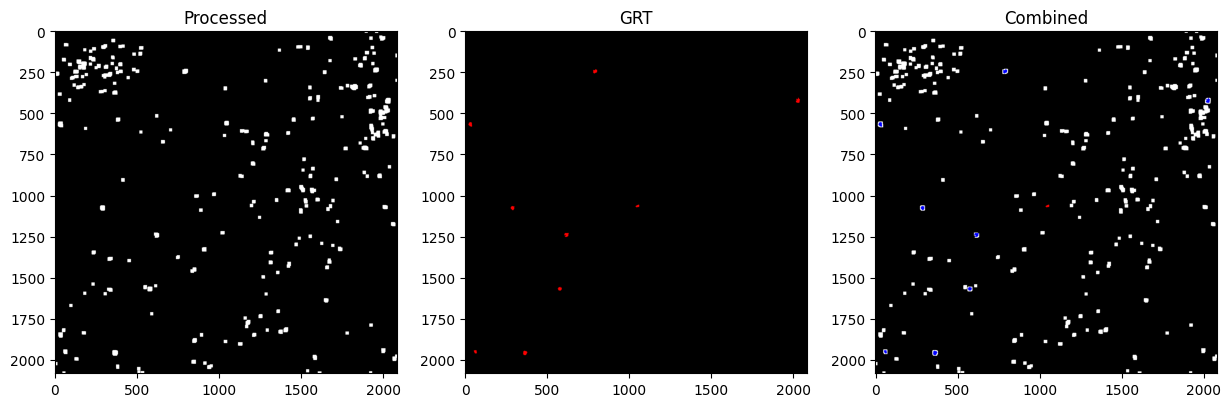

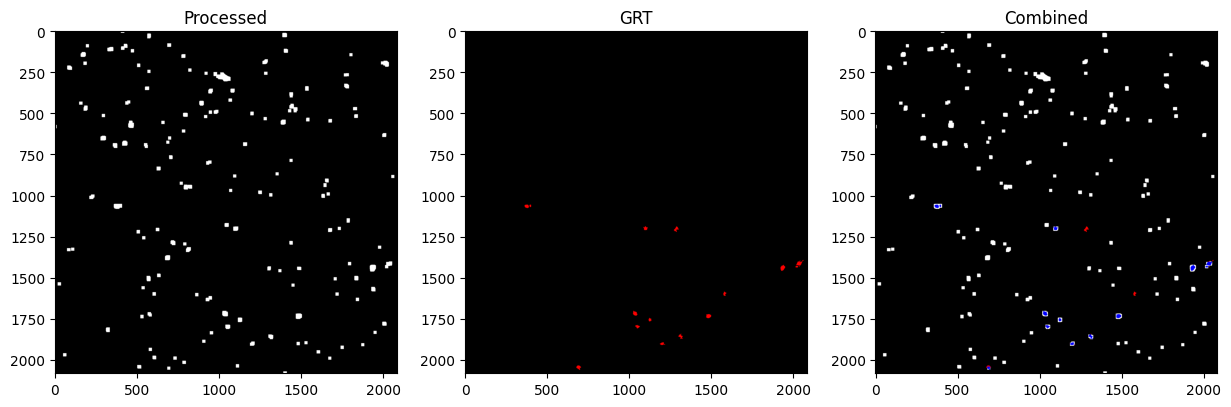

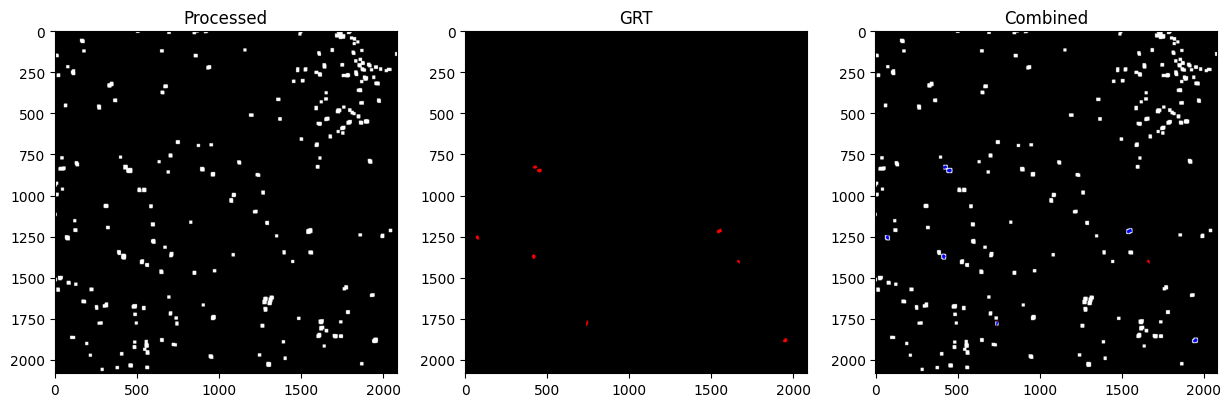

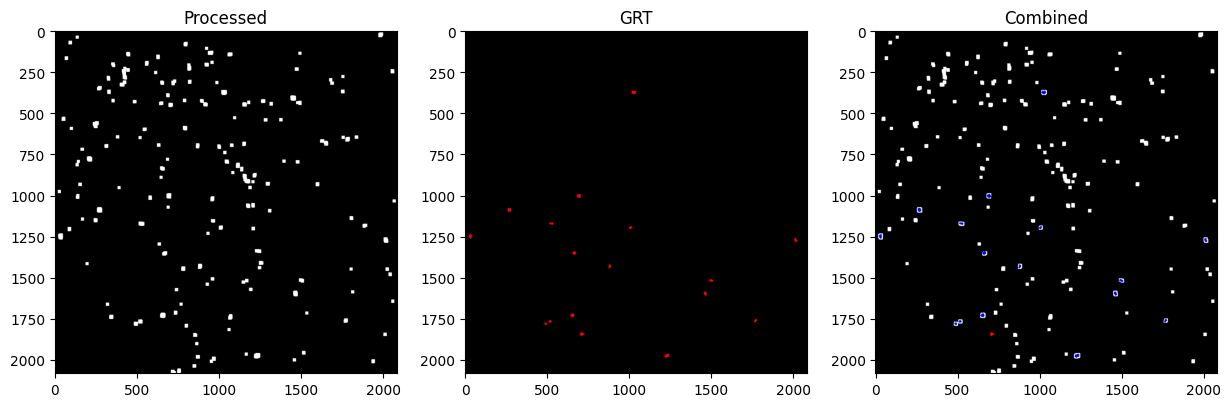

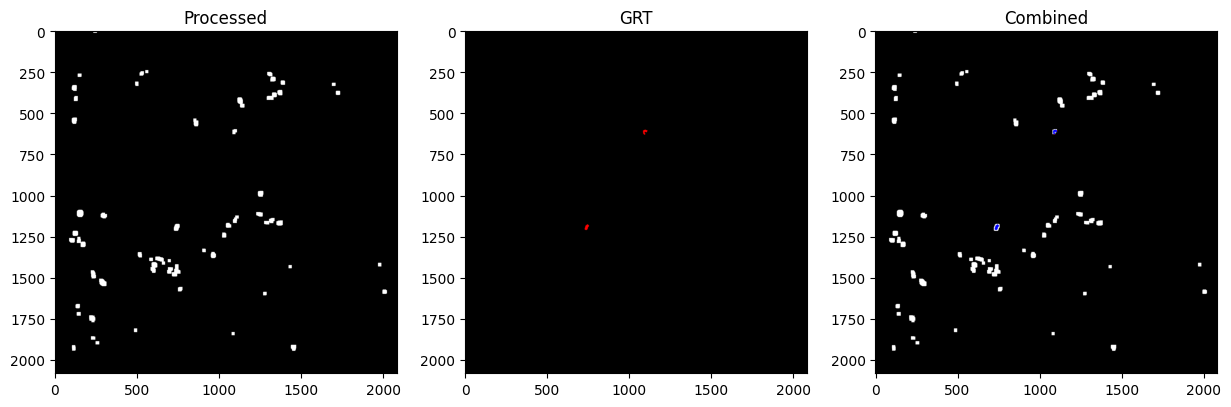

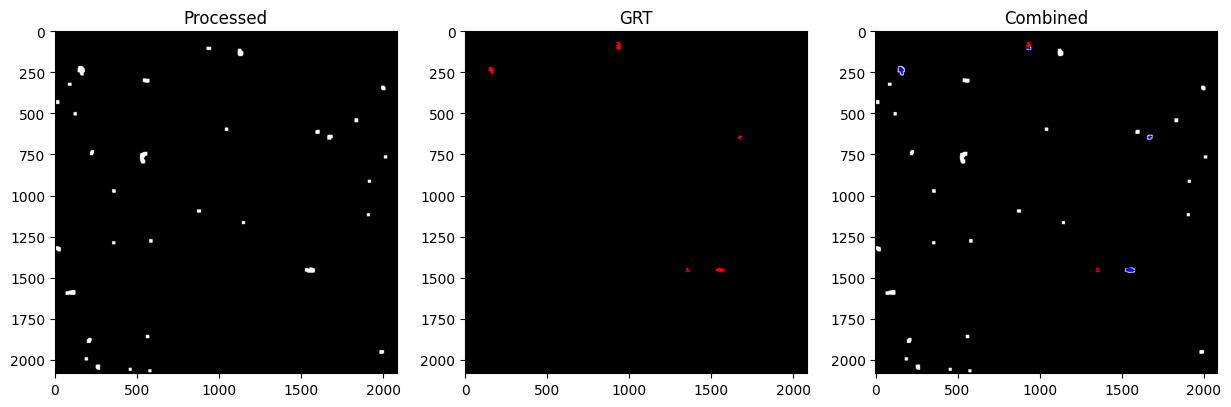

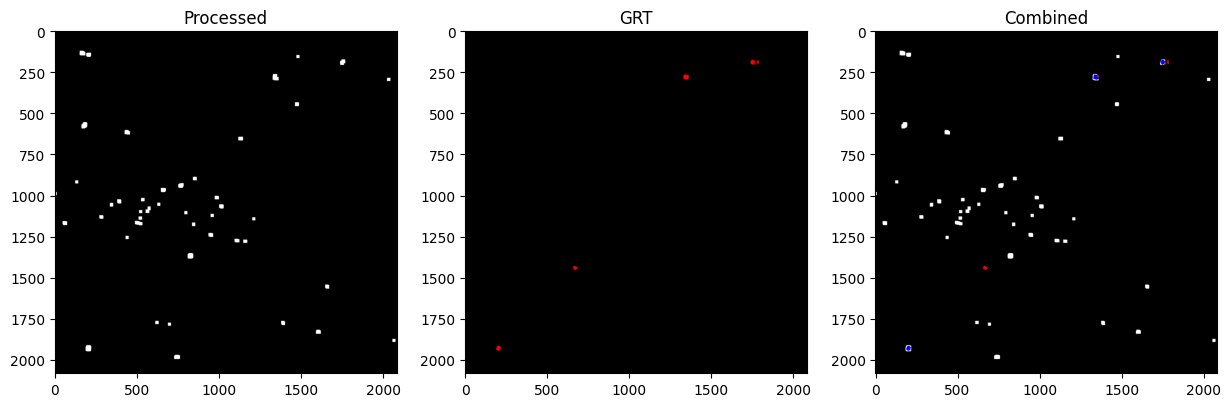

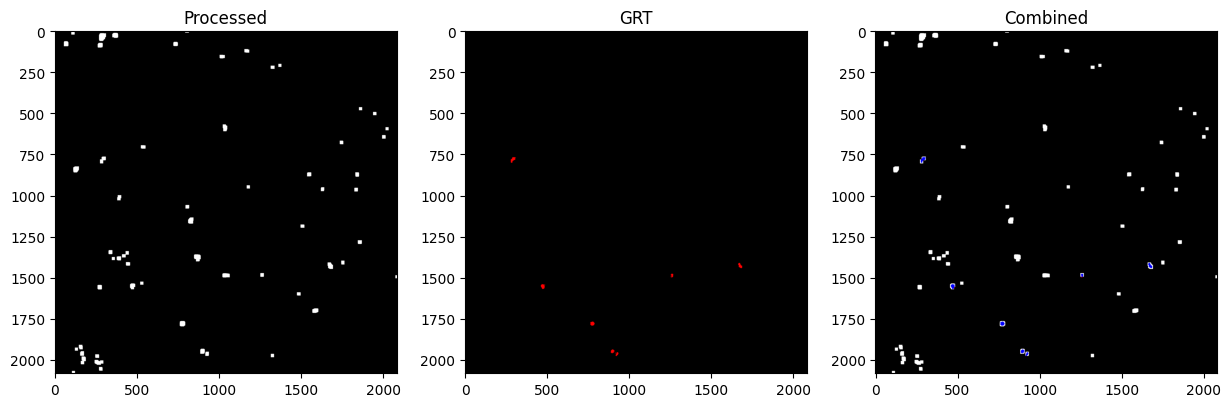

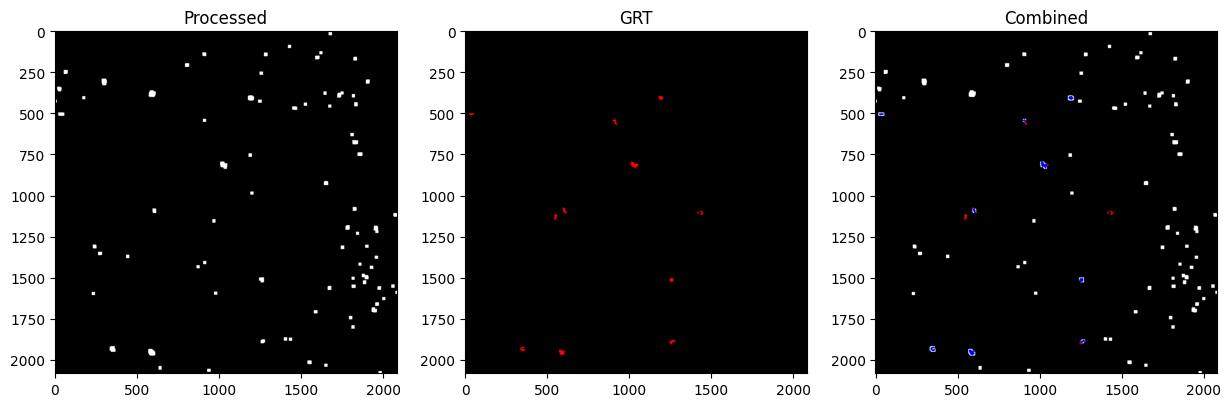

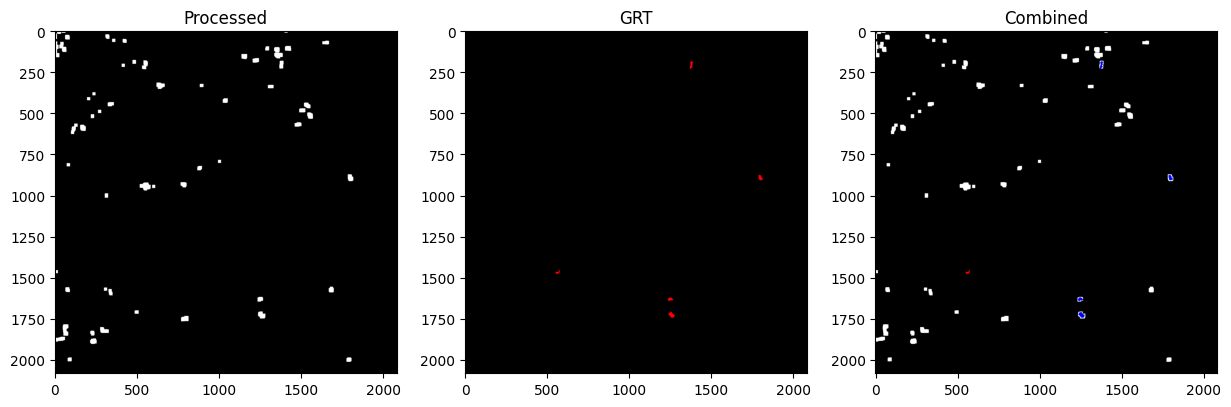

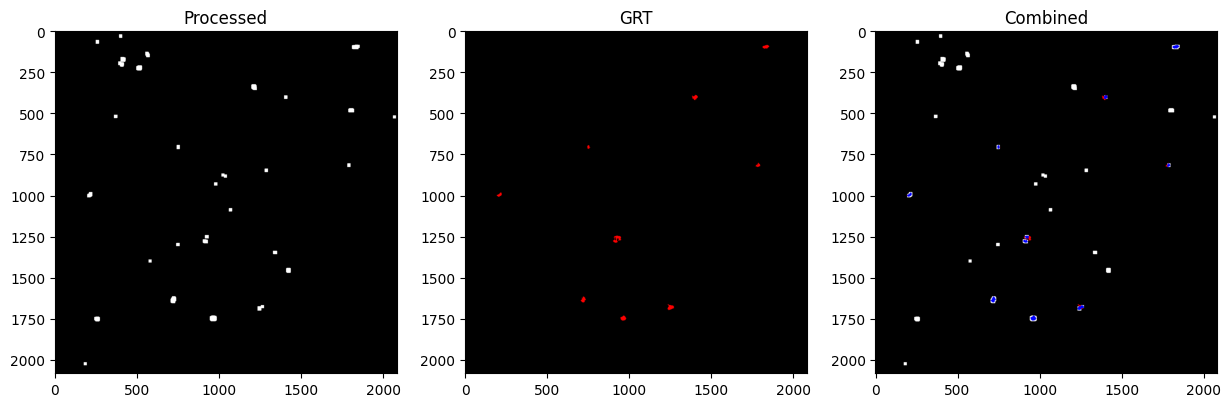

In [ ]:
def visualize_combined_mask(image_path, csv_path):
    # Load and preprocess
    original = cv2.imread(image_path)
    height, width = original.shape[:2]
    processed = preprocess_and_segment(image_path)
    visualized_mitosis = ground_truth(image_path,csv_path)

    # --- Connected components just for stats ---
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(processed)

    # --- Create GT mask from CSV ---
    gt_mask = np.zeros((height, width), dtype=np.uint8)
    mitosis_points = []

    if os.path.exists(csv_path):
        with open(csv_path, 'r') as file:
            for line in file:
                values = list(map(int, line.strip().split(',')))
                coords = list(zip(values[::2], values[1::2]))
                mitosis_points.extend(coords)

        for x, y in mitosis_points:
            if 0 <= x < width and 0 <= y < height:
                gt_mask[y, x] = 255  # White pixel for GT

    # --- Compute masks ---
    pred_mask = processed > 0
    gt_mask_bin = gt_mask > 0

    intersection = np.logical_and(pred_mask, gt_mask_bin)
    only_pred = np.logical_and(pred_mask, ~gt_mask_bin)
    only_gt = np.logical_and(~pred_mask, gt_mask_bin)

    # --- Create a blank 3-channel image ---
    combined = np.zeros((height, width, 3), dtype=np.uint8)

    # Color pixels based on condition
    combined[only_pred] = [255, 255, 255]    # ⚪ White for only predicted
    combined[only_gt] = [0, 0, 255]          # 🔴 Red for only ground truth
    combined[intersection] = [255, 0, 0]     # 🔵 Blue for intersection

    # --- IoU Calculation ---
    intersection_area = intersection.sum()
    union_area = np.logical_or(pred_mask, gt_mask_bin).sum()
    iou = intersection_area / union_area if union_area > 0 else 0

    print(f"📍 Image: {os.path.basename(image_path)}")
    print(f"✅ Connected Components (excluding background): {num_labels - 1}")
    print(f"⚪ Segmented Area: {pred_mask.sum()}")
    print(f"🔴 Ground Truth Area: {gt_mask_bin.sum()}")
    print(f"🔵 Intersection Area: {intersection_area}")
    print(f"📏 IoU: {iou:.4f}")

    # --- Display ---
    plot_three_side(processed,visualized_mitosis,combined,"Processed","GRT","Combined")
    return intersection_area


# 🔁 Loop through training images
total = 0
for train in train_folder_names:
    for subdir, _, files in os.walk(os.path.join(image_folder + train)):
        for file in files:
            if file.endswith(".bmp"):
                image_path = os.path.join(subdir, file)
                csv_path = os.path.join(subdir, os.path.splitext(file)[0] + '.csv')
                total += visualize_combined_mask(image_path, csv_path)
print("TOTAL INTERSECTION AREA = ",total)


# **Stage 3) numerical feature vector**

In [ ]:
num_clusters = 100  # Number of visual words

def train_bovw_dictionary(image_folder, train_folder_names, num_clusters=100):
    """Train a BoVW dictionary using SIFT descriptors from all training images."""

    sift = cv2.SIFT_create()
    all_descriptors = []

    for train in train_folder_names:
        train_path = os.path.join(image_folder + train)
        print(train_path)
        for subdir, _, files in os.walk(train_path):
            image_files = [f for f in files if f.endswith('.bmp')]

            for image_file in image_files:
                image_path = os.path.join(subdir, image_file)
                gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                # Extract SIFT features
                keypoints, descriptors = sift.detectAndCompute(gray_image, None)
                if descriptors is not None:
                    all_descriptors.append(descriptors)

    if len(all_descriptors) == 0:
        print("No descriptors found in training images.")
        return None

    # Stack descriptors and train K-Means
    all_descriptors = np.vstack(all_descriptors)
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(all_descriptors)

    print(f"Trained BoVW dictionary with {num_clusters} visual words.")
    return kmeans


In [ ]:
import matplotlib.pyplot as plt

def visualize_mitosis_pixelwise(segmented_image, labels, stats, matched_labels, mitosis_points, mitosis_radius=10):
    """
    Visualizes:
    🟩 Green = True Positive (IoU matched mitotic region)
    🟥 Red   = False Positive (non-mitotic region)
    🔵 Blue  = Ground Truth mitosis pixels from CSV
    """

    h, w = segmented_image.shape
    vis_image = np.zeros((h, w, 3), dtype=np.uint8)
    # 2️⃣ Draw ground truth mitosis pixel regions in blue
    for (x, y) in mitosis_points:
        if 0 <= x < w and 0 <= y < h:
            vis_image[y - mitosis_radius:y + mitosis_radius, x - mitosis_radius:x + mitosis_radius] = [255, 0, 0]  # Blue

    # 1️⃣ Draw predicted regions
    for i in range(1, len(stats)):  # Skip background
        region_mask = (labels == i)
        if matched_labels[i] == 1:
            vis_image[region_mask] = [0, 255, 0]  # Green for mitotic
        else:
            vis_image[region_mask] = [0, 0, 255]  # Red for non-mitotic



    # 3️⃣ Show image
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(vis_image, cv2.COLOR_BGR2RGB))
    plt.title("🟩 Matched Mitotic | 🟥 Non-Mitotic | 🔵 GT Mitosis (Pixels)")
    plt.axis("off")
    plt.show()

#used in checking extracting feature threshold in the below code


In [ ]:
def extract_cell_features(image_path, segmented_image, kmeans, mitosis_csv_path=None, num_clusters=100, include_labels=True):
    """Extract BoVW + Texture Features per cell. Optionally assign labels using IoU if CSV is available."""

    gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    color_image = cv2.imread(image_path)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(segmented_image)
    print(f"For {image_path} there is {num_labels}# connected components")
    sift = cv2.SIFT_create()
    all_features = []

    mitosis_points = []
    if include_labels and mitosis_csv_path and os.path.exists(mitosis_csv_path):
        with open(mitosis_csv_path, 'r') as file:
            for line in file:
                values = line.strip().split(',')
                coords = list(zip(map(int, values[::2]), map(int, values[1::2])))
                mitosis_points.extend(coords)
        matched_labels = match_mitosis_by_iou(stats, mitosis_points)

        #Added for correctly setting threshold

        #visualize_mitosis_pixelwise(segmented_image, labels, stats, matched_labels, mitosis_points)

    else:
        matched_labels = [0] * num_labels  # default to non-mitotic if not using labels

    for i in range(1, num_labels):  # Ignore background
        center_x, center_y = int(centroids[i][0]), int(centroids[i][1])
        x, y, w, h = stats[i, cv2.CC_STAT_LEFT], stats[i, cv2.CC_STAT_TOP], stats[i, cv2.CC_STAT_WIDTH], stats[i, cv2.CC_STAT_HEIGHT]
        cell_patch = gray_image[y:y+h, x:x+w]
        color_patch = color_image[y:y+h, x:x+w]

        keypoints, descriptors = sift.detectAndCompute(cell_patch, None)
        if descriptors is not None:
            words = kmeans.predict(descriptors)
            bovw_histogram, _ = np.histogram(words, bins=np.arange(num_clusters + 1))
        else:
            bovw_histogram = np.zeros(num_clusters)

        # **Texture Features (LBP & GLCM)**
        lbp = local_binary_pattern(cell_patch, P=8, R=1, method='uniform')
        lbp_hist = np.histogram(lbp, bins=np.arange(0, 11), density=True)[0]

        glcm = graycomatrix(cell_patch, distances=[1], angles=[0], symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        energy = graycoprops(glcm, 'energy')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        correlation = graycoprops(glcm, 'correlation')[0, 0]

        # **Shape Features**
        aspect_ratio = w / float(h)  # Width / Height
        solidity = stats[i, cv2.CC_STAT_AREA] / (w * h)  # Area / Bounding Box Area

        # Find Contours for Perimeter and Circularity
        mask = (labels == i).astype(np.uint8)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        perimeter = cv2.arcLength(contours[0], True) if contours else 0
        circularity = (4 * np.pi * stats[i, cv2.CC_STAT_AREA]) / (perimeter ** 2) if perimeter > 0 else 0

        # **Color Features (Mean & Std in HSV)**
        hsv_patch = cv2.cvtColor(color_patch, cv2.COLOR_BGR2HSV)
        mean_h, mean_s, mean_v = np.mean(hsv_patch, axis=(0, 1))
        std_h, std_s, std_v = np.std(hsv_patch, axis=(0, 1))

        label = matched_labels[i] if include_labels and i < len(matched_labels) else None  # 🚀 Use None for test data

        features = [image_path, center_x, center_y, contrast, energy, homogeneity, correlation,
                    aspect_ratio, solidity, circularity, perimeter, mean_h, mean_s, mean_v, std_h, std_s, std_v,
                    *lbp_hist, *bovw_histogram, label]
        all_features.append(features)

    columns = ["Image", "Center_X", "Center_Y", "GLCM_Contrast", "GLCM_Energy",
               "GLCM_Homogeneity", "GLCM_Correlation", "Aspect_Ratio", "Solidity", "Circularity", "Perimeter",
               "Mean_H", "Mean_S", "Mean_V", "Std_H", "Std_S", "Std_V"] + \
              [f"LBP_{i}" for i in range(10)] + [f"Cluster_{i}" for i in range(num_clusters)] + ["Label"]

    return pd.DataFrame(all_features, columns=columns)


In [ ]:
def process_all_images(image_folder, folder_names, kmeans, num_clusters=100, include_labels=True):
    all_data = []

    for folder in folder_names:
        folder_path = os.path.join(image_folder + folder)

        print(folder_path)
        for subdir, _, files in os.walk(folder_path):
            for file in files:
                if file.endswith('.bmp'):
                    image_path = os.path.join(subdir, file)
                    print(f"Folder, {image_path} is currently processing.")
                    csv_path = os.path.join(subdir, file.replace('.bmp', '.csv')) if include_labels else None

                    segmented = preprocess_and_segment(image_path)
                    df = extract_cell_features(image_path, segmented, kmeans, csv_path, num_clusters, include_labels)
                    all_data.append(df)

    final_df = pd.concat(all_data, ignore_index=True)
    output_path = os.path.join(image_folder, "labeled_features.csv" if include_labels else "unlabeled_features.csv")
    final_df.to_csv(output_path, index=False)
    print(f"✅ Saved feature dataset to {output_path}")


In [ ]:
kmeans = train_bovw_dictionary(image_folder, train_folder_names, num_clusters=100)

/content/drive/MyDrive/SPRING 2024-2025/EE417/Homeworks/takehome1/scanner_A/A01_v2
/content/drive/MyDrive/SPRING 2024-2025/EE417/Homeworks/takehome1/scanner_A/A03_v2
/content/drive/MyDrive/SPRING 2024-2025/EE417/Homeworks/takehome1/scanner_A/A04_v2
Trained BoVW dictionary with 100 visual words.


In [ ]:
def compute_iou(box1, box2):
    """Computes IoU (Intersection over Union) between two bounding boxes."""
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Compute intersection
    xi1, yi1 = max(x1, x2), max(y1, y2)
    xi2, yi2 = min(x1 + w1, x2 + w2), min(y1 + h1, y2 + h2)
    intersection = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    # Compute union
    area1 = w1 * h1
    area2 = w2 * h2
    union = area1 + area2 - intersection

    return intersection / union if union > 0 else 0

def match_mitosis_by_iou(stats, mitosis_points, mitosis_radius=10, iou_threshold=0.1):
    """
    Matches detected cell regions with mitosis ground-truth points using IoU.
    Returns an array of labels (1 = mitotic, 0 = non-mitotic).
    """
    labels = np.zeros(len(stats))  # Default: all cells are non-mitotic

    # Convert mitosis points to bounding boxes (assuming circular regions)
    mitosis_boxes = [(x - mitosis_radius, y - mitosis_radius, 2 * mitosis_radius, 2 * mitosis_radius)
                     for x, y in mitosis_points]

    for i, (x, y, w, h, _) in enumerate(stats):
        detected_box = (x, y, w, h)

        for mitosis_box in mitosis_boxes:
            if compute_iou(detected_box, mitosis_box) > iou_threshold:
                labels[i] = 1  # Assign as mitotic cell
                break

    return labels


In [ ]:
process_all_images(image_folder, train_folder_names, kmeans, num_clusters=100)

/content/drive/MyDrive/SPRING 2024-2025/EE417/Homeworks/takehome1/scanner_A/A01_v2
Folder, /content/drive/MyDrive/SPRING 2024-2025/EE417/Homeworks/takehome1/scanner_A/A01_v2/A01_05.bmp is currently processing.
For /content/drive/MyDrive/SPRING 2024-2025/EE417/Homeworks/takehome1/scanner_A/A01_v2/A01_05.bmp there is 149# connected components
Folder, /content/drive/MyDrive/SPRING 2024-2025/EE417/Homeworks/takehome1/scanner_A/A01_v2/A01_01.bmp is currently processing.
For /content/drive/MyDrive/SPRING 2024-2025/EE417/Homeworks/takehome1/scanner_A/A01_v2/A01_01.bmp there is 173# connected components
Folder, /content/drive/MyDrive/SPRING 2024-2025/EE417/Homeworks/takehome1/scanner_A/A01_v2/A01_02.bmp is currently processing.
For /content/drive/MyDrive/SPRING 2024-2025/EE417/Homeworks/takehome1/scanner_A/A01_v2/A01_02.bmp there is 76# connected components
Folder, /content/drive/MyDrive/SPRING 2024-2025/EE417/Homeworks/takehome1/scanner_A/A01_v2/A01_08.bmp is currently processing.
For /conten

# **Stage 4) training a classifier**

In [ ]:
# For training:
process_all_images(image_folder, ["/A01_v2", "/A03_v2", "/A04_v2", "/A02_v2"], kmeans, include_labels=True)

# For validation/test:
process_all_images(image_folder, ["/A00_v2"], kmeans, include_labels=False)

/content/drive/MyDrive/SPRING 2024-2025/EE417/Homeworks/takehome1/scanner_A/A01_v2
Folder, /content/drive/MyDrive/SPRING 2024-2025/EE417/Homeworks/takehome1/scanner_A/A01_v2/A01_05.bmp is currently processing.
For /content/drive/MyDrive/SPRING 2024-2025/EE417/Homeworks/takehome1/scanner_A/A01_v2/A01_05.bmp there is 149# connected components
Folder, /content/drive/MyDrive/SPRING 2024-2025/EE417/Homeworks/takehome1/scanner_A/A01_v2/A01_01.bmp is currently processing.
For /content/drive/MyDrive/SPRING 2024-2025/EE417/Homeworks/takehome1/scanner_A/A01_v2/A01_01.bmp there is 173# connected components
Folder, /content/drive/MyDrive/SPRING 2024-2025/EE417/Homeworks/takehome1/scanner_A/A01_v2/A01_02.bmp is currently processing.
For /content/drive/MyDrive/SPRING 2024-2025/EE417/Homeworks/takehome1/scanner_A/A01_v2/A01_02.bmp there is 76# connected components
Folder, /content/drive/MyDrive/SPRING 2024-2025/EE417/Homeworks/takehome1/scanner_A/A01_v2/A01_08.bmp is currently processing.
For /conten

In [ ]:
# Labeled features (used for training)
df_labeled = pd.read_csv(f"{image_folder}/labeled_features.csv")

# Unlabeled features (used for inference — no true label inside)
df_unlabeled = pd.read_csv(f"{image_folder}/unlabeled_features.csv")


In [ ]:
# Define folders
train_folders = ["A01_v2", "A03_v2", "A04_v2"]
val_folder = "A02_v2"
test_folder = "A00_v2"

# Filter labeled training data
df_train = df_labeled[df_labeled["Image"].str.contains('|'.join([f"{image_folder}/{f}" for f in train_folders]))]

df_val = df_labeled[df_labeled["Image"].str.contains(f"{image_folder}/{val_folder}")]

# Filter test features from unlabeled
df_test = df_unlabeled[df_unlabeled["Image"].str.contains(f"{image_folder}/{test_folder}")]

print(f"Train: {df_train.shape} | Val: {df_val.shape} | Test (unlabeled): {df_test.shape}")


Train: (2389, 128) | Val: (2358, 128) | Test (unlabeled): (2819, 128)


In [ ]:
df_train.columns

Index(['Image', 'Center_X', 'Center_Y', 'GLCM_Contrast', 'GLCM_Energy',
       'GLCM_Homogeneity', 'GLCM_Correlation', 'Aspect_Ratio', 'Solidity',
       'Circularity',
       ...
       'Cluster_91', 'Cluster_92', 'Cluster_93', 'Cluster_94', 'Cluster_95',
       'Cluster_96', 'Cluster_97', 'Cluster_98', 'Cluster_99', 'Label'],
      dtype='object', length=128)

In [ ]:
df_val.columns

Index(['Image', 'Center_X', 'Center_Y', 'GLCM_Contrast', 'GLCM_Energy',
       'GLCM_Homogeneity', 'GLCM_Correlation', 'Aspect_Ratio', 'Solidity',
       'Circularity',
       ...
       'Cluster_91', 'Cluster_92', 'Cluster_93', 'Cluster_94', 'Cluster_95',
       'Cluster_96', 'Cluster_97', 'Cluster_98', 'Cluster_99', 'Label'],
      dtype='object', length=128)

In [ ]:
df_test.columns

Index(['Image', 'Center_X', 'Center_Y', 'GLCM_Contrast', 'GLCM_Energy',
       'GLCM_Homogeneity', 'GLCM_Correlation', 'Aspect_Ratio', 'Solidity',
       'Circularity',
       ...
       'Cluster_91', 'Cluster_92', 'Cluster_93', 'Cluster_94', 'Cluster_95',
       'Cluster_96', 'Cluster_97', 'Cluster_98', 'Cluster_99', 'Label'],
      dtype='object', length=128)

In [ ]:
def prepare_xy(df_part, labeled=True):
    """Extract features (X) and labels (y) from the dataset"""
    drop_columns = ["Image", "Center_X", "Center_Y"]
    if labeled:
        drop_columns.append("Label")  # 🚀 Ensure 'Label' is removed from X
        return df_part.drop(columns=drop_columns), df_part["Label"]
    return df_part.drop(columns=drop_columns), None  # For test data, don't return labels

# Prepare Training and Validation Sets
X_train, y_train = prepare_xy(df_train, labeled=True)
X_val, y_val = prepare_xy(df_val, labeled=True)

# Prepare Test Set (🚀 Unlabeled Features)
X_test, _ = prepare_xy(df_test, labeled=True)  # No labels in test!



In [ ]:
from imblearn.over_sampling import SMOTE

print("⚖️ Before SMOTE:", y_train.value_counts().to_dict())  # Debugging 🚀

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("✅ After SMOTE:", pd.Series(y_train_bal).value_counts().to_dict())  # Check if balanced 🚀

print("Doesn't used due to high false positive")

⚖️ Before SMOTE: {0.0: 2228, 1.0: 161}
✅ After SMOTE: {0.0: 2228, 1.0: 2228}
Doesn't used due to high false positive


In [ ]:
# Train Model
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_leaf=3,
    min_samples_split=4,
    class_weight="balanced",
    random_state=42
)
#clf.fit(X_train_bal, y_train_bal)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=3, min_samples_split=4,
                       n_estimators=200, random_state=42)

In [ ]:
def print_class_accuracy(y_true, y_pred, label_names=["Non-Mitotic", "Mitotic"]):
    """
    Prints accuracy for each class based on the confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)

    for i, label in enumerate(label_names):
        total = cm[i].sum()
        correct = cm[i, i]
        acc = correct / total if total > 0 else 0
        print(f"✅ Accuracy ({label}): {acc:.2%}")


In [ ]:
# Predict on validation set
#X_val.drop(columns=["Predicted_Label"], inplace=True)
y_pred_val = clf.predict(X_val)
df_val = df_val.copy()  # just in case it's a slice
df_val["Predicted_Label"] = y_pred_val
print("\n📊 Validation Results (from labeled_features.csv):")
print("F1 Score:", f1_score(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val, target_names=["Non-Mitotic", "Mitotic"]))
print_class_accuracy(y_val, y_pred_val)

# Predict on test set (A00_v2)
# Predict on Test Set (A00)
#X_test.drop(columns=["Predicted_Label"], inplace=True)
y_pred_test = clf.predict(X_test)  # 🚀 Should now work correctly!
df_test["Predicted_Label"] = y_pred_test





📊 Validation Results (from labeled_features.csv):
F1 Score: 0.2777777777777778
              precision    recall  f1-score   support

 Non-Mitotic       0.99      1.00      0.99      2334
     Mitotic       0.42      0.21      0.28        24

    accuracy                           0.99      2358
   macro avg       0.70      0.60      0.64      2358
weighted avg       0.99      0.99      0.99      2358

✅ Accuracy (Non-Mitotic): 99.70%
✅ Accuracy (Mitotic): 20.83%


In [ ]:
df_test.head()

Image  Center_X  Center_Y  \
0  /content/drive/MyDrive/SPRING 2024-2025/EE417/...       964         4   
1  /content/drive/MyDrive/SPRING 2024-2025/EE417/...      1049         5   
2  /content/drive/MyDrive/SPRING 2024-2025/EE417/...      1674         4   
3  /content/drive/MyDrive/SPRING 2024-2025/EE417/...       656        11   
4  /content/drive/MyDrive/SPRING 2024-2025/EE417/...       846        16   

   GLCM_Contrast  GLCM_Energy  GLCM_Homogeneity  GLCM_Correlation  \
0     260.947368     0.054868          0.123099          0.942538   
1     184.730769     0.045656          0.106023          0.942035   
2      91.478261     0.053688          0.188875          0.984568   
3     330.704678     0.040410          0.057456          0.945708   
4     224.407692     0.035198          0.093139          0.947608   

   Aspect_Ratio  Solidity  Circularity  ...  Cluster_92  Cluster_93  \
0      1.818182  0.995455     0.834863  ...         0.0         0.0   
1      1.769231  0.986622     0.830060  ...         0.0         0.0   
2      2.181818  0.992424     0.769426  ...         0.0         0.0   
3      1.000000  1.000000     0.875089  ...         0.0         0.0   
4      0.807692  0.985348     0.868231  ...         0.0         0.0   

   Cluster_94  Cluster_95  Cluster_96  Cluster_97  Cluster_98  Cluster_99  \
0         0.0         0.0         0.0         0.0         0.0         0.0   
1         0.0         0.0         1.0         0.0         0.0         0.0   
2         0.0         0.0         0.0         0.0         0.0         0.0   
3         0.0         0.0         0.0         0.0         0.0         0.0   
4         0.0         0.0         1.0         0.0         0.0         0.0   

   Label  Predicted_Label  
0    NaN              0.0  
1    NaN              0.0  
2    NaN              0.0  
3    NaN              0.0  
4    NaN              0.0  

[5 rows x 129 columns]

In [ ]:
# Evaluate Performance
print("\n📊 Validation Results:")
print("F1 Score:", f1_score(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val, target_names=["Non-Mitotic", "Mitotic"]))


📊 Validation Results:
F1 Score: 0.2777777777777778
              precision    recall  f1-score   support

 Non-Mitotic       0.99      1.00      0.99      2334
     Mitotic       0.42      0.21      0.28        24

    accuracy                           0.99      2358
   macro avg       0.70      0.60      0.64      2358
weighted avg       0.99      0.99      0.99      2358



📏 Pixel-wise IoU for A02_02.bmp: 0.1171
📏 Pixel-wise IoU for A02_05.bmp: 0.0000
📏 Pixel-wise IoU for A02_09.bmp: 0.0000
📏 Pixel-wise IoU for A02_04.bmp: 0.1017
📏 Pixel-wise IoU for A02_06.bmp: 0.2445
📏 Pixel-wise IoU for A02_08.bmp: 0.1898

✅ Mean Pixel-wise IoU across 6 images in A02_v2: 0.1089


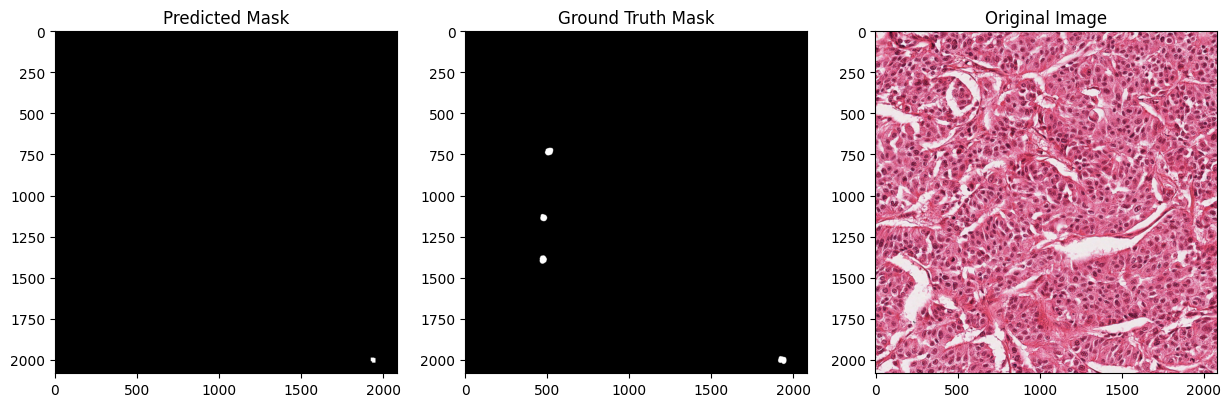

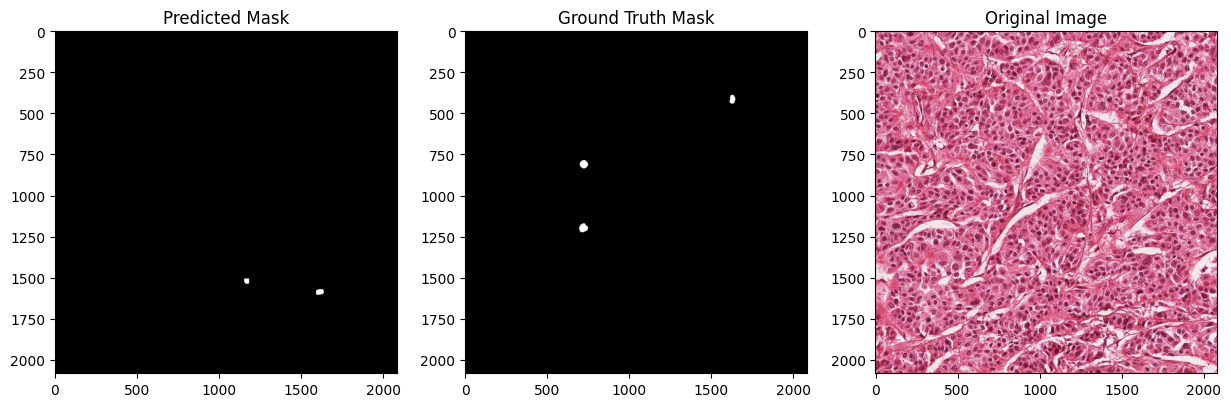

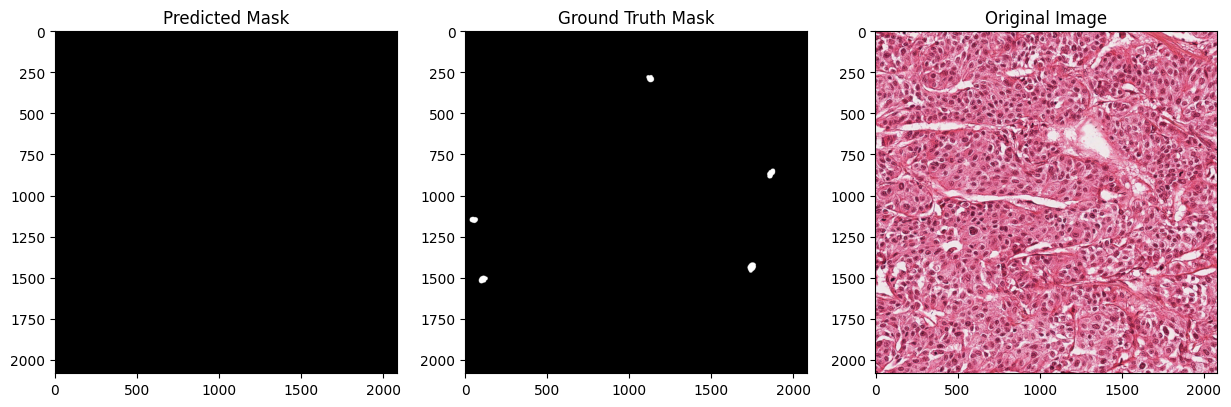

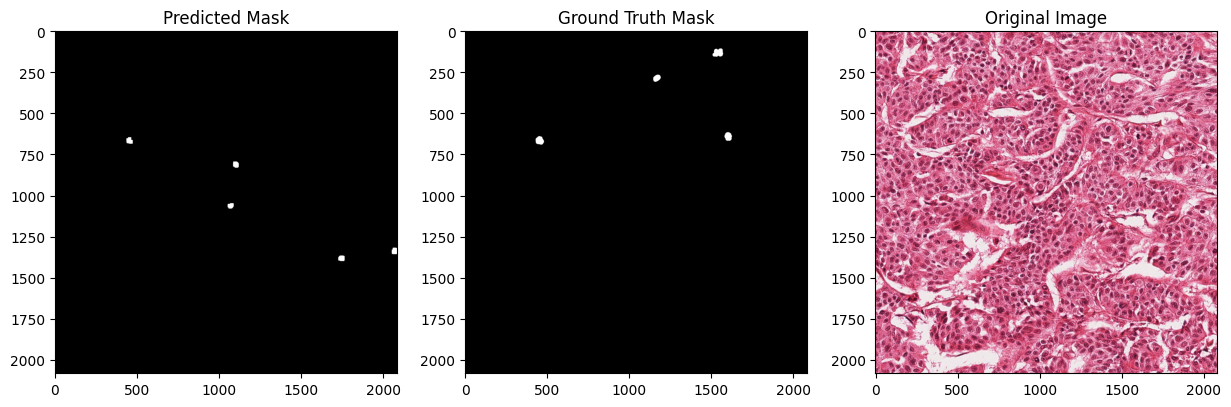

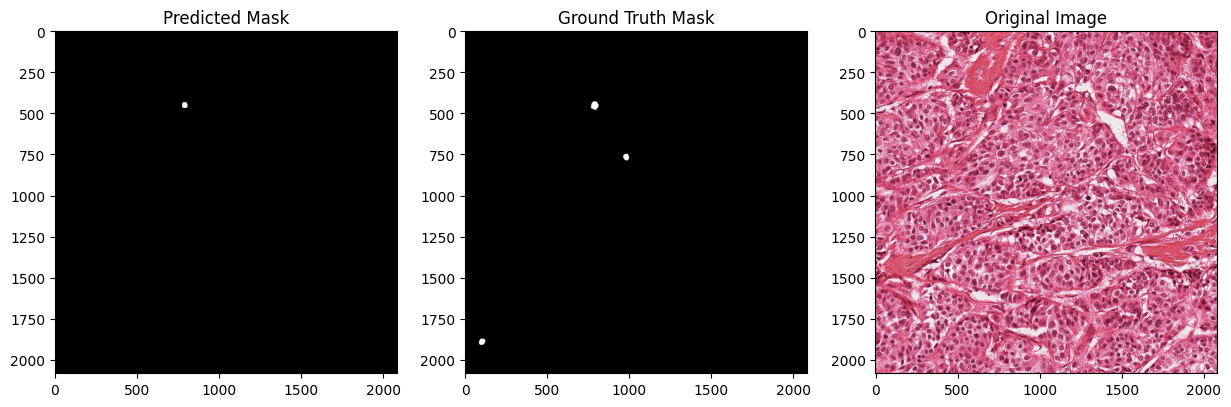

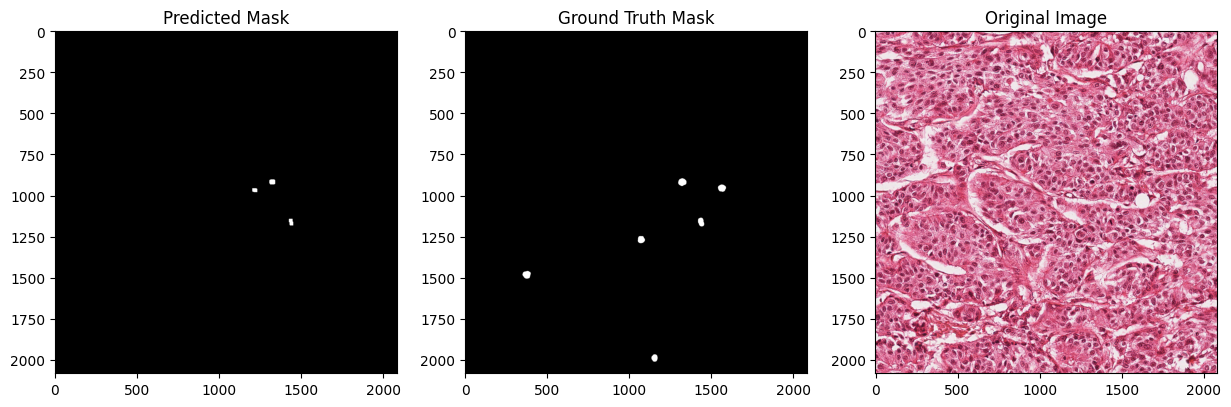

In [ ]:
ious = []

folder_name = "A02_v2"
folder_path = os.path.join(image_folder, folder_name)

def compute_mask_iou(pred_mask, gt_mask):
    """Compute IoU between two binary masks."""
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    return intersection / union if union != 0 else 0

for subdir, _, files in os.walk(folder_path):
    for file in files:
        if file.endswith(".bmp"):
            image_name = file
            image_path = os.path.join(subdir, image_name)
            original_image = cv2.imread(image_path)
            segmented_image = preprocess_and_segment(image_path)

            # Load prediction labels from dataframe
            pred_df_image = df_val[df_val["Image"].str.contains(image_name)]
            pred_centroids = pred_df_image[pred_df_image["Predicted_Label"] == 1][["Center_X", "Center_Y"]].values.astype(int)

            # Connected components
            num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(segmented_image)

            # Build predicted pixel mask
            pred_mask = np.zeros_like(segmented_image)
            for i in range(1, num_labels):  # Skip background
                cx, cy = map(int, centroids[i])
                if any(np.linalg.norm(pred_centroids - [cx, cy], axis=1) < 5):  # Match centroids within radius
                    pred_mask[labels == i] = 255

            # Build ground truth pixel mask from CSV using mitosis coordinates
            gt_mask = np.zeros_like(segmented_image)
            csv_path = os.path.join(subdir, image_name.replace(".bmp", ".csv"))
            mitosis_points = []

            if os.path.exists(csv_path):
                with open(csv_path, 'r') as file:
                    for line in file:
                        values = line.strip().split(',')
                        coords = list(zip(map(int, values[::2]), map(int, values[1::2])))
                        mitosis_points.extend(coords)

                for x, y in mitosis_points:
                    if 0 <= x < gt_mask.shape[1] and 0 <= y < gt_mask.shape[0]:
                        cv2.circle(gt_mask, (x, y), 10, 255, -1)  # Ground truth region = white in binary mask

            else:
                print(f"⚠️ CSV not found for: {image_name}")

            # IoU Calculation
            iou = compute_mask_iou(pred_mask > 0, gt_mask > 0)
            ious.append(iou)
            print(f"📏 Pixel-wise IoU for {image_name}: {iou:.4f}")

            # Optional Visualization
            plot_three_side(pred_mask, gt_mask, original_image, title1="Predicted Mask", title2="Ground Truth Mask",title3="Original Image")

# 📊 Summary
mean_iou = np.mean(ious) if ious else 0
print(f"\n✅ Mean Pixel-wise IoU across {len(ious)} images in {folder_name}: {mean_iou:.4f}")


📏 Pixel-wise IoU for A00_03.bmp: 0.0000
📏 Pixel-wise IoU for A00_05.bmp: 0.5032
📏 Pixel-wise IoU for A00_01.bmp: 0.2784
📏 Pixel-wise IoU for A00_06.bmp: 0.2826
📏 Pixel-wise IoU for A00_09.bmp: 0.2013
📏 Pixel-wise IoU for A00_07.bmp: 0.3432
📏 Pixel-wise IoU for A00_02.bmp: 0.4933
📏 Pixel-wise IoU for A00_04.bmp: 0.0000

✅ Mean Pixel-wise IoU across 8 images in A00_v2: 0.2627


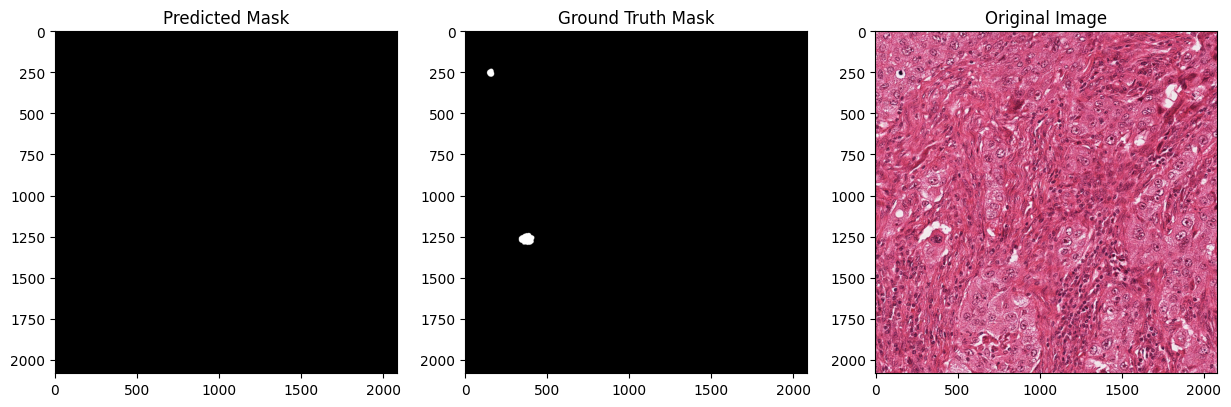

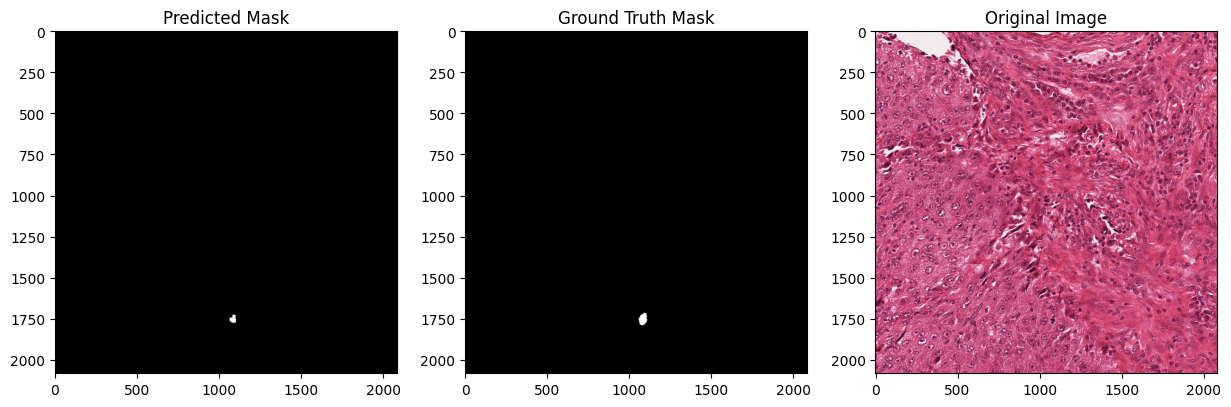

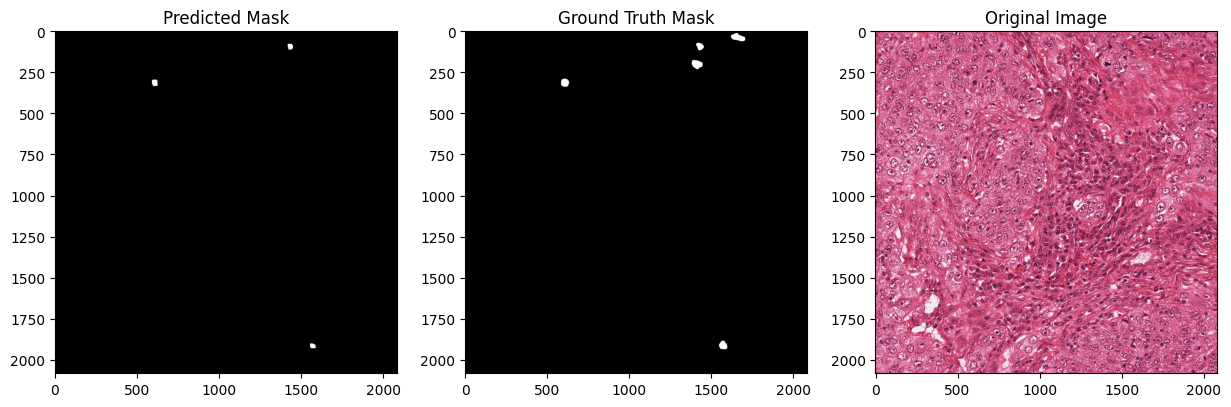

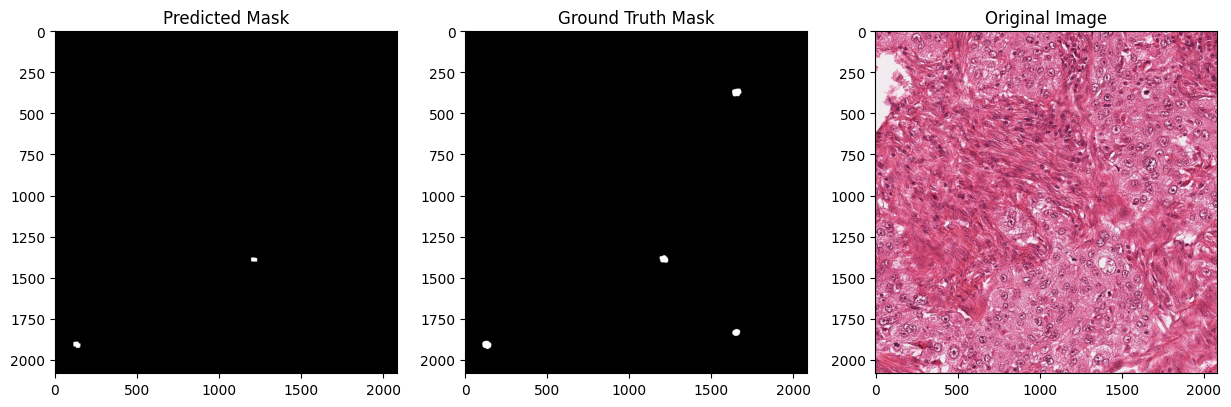

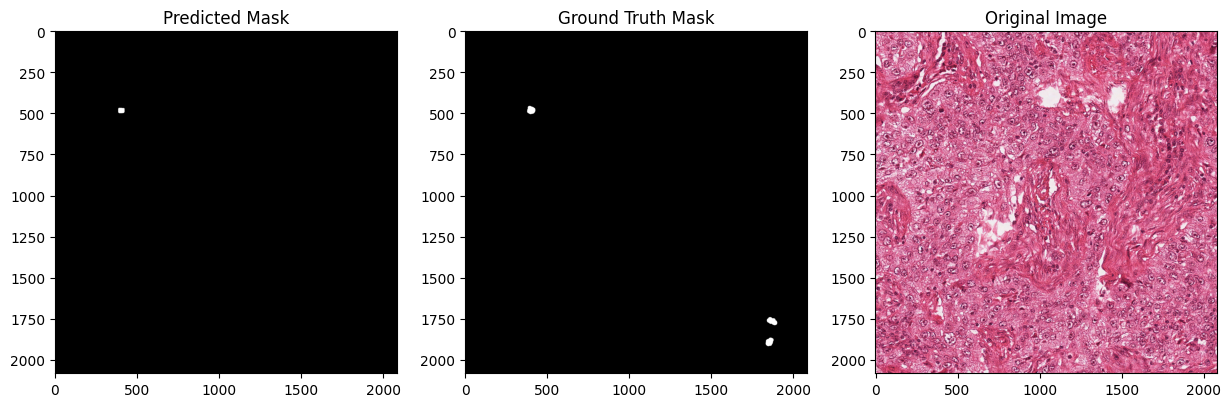

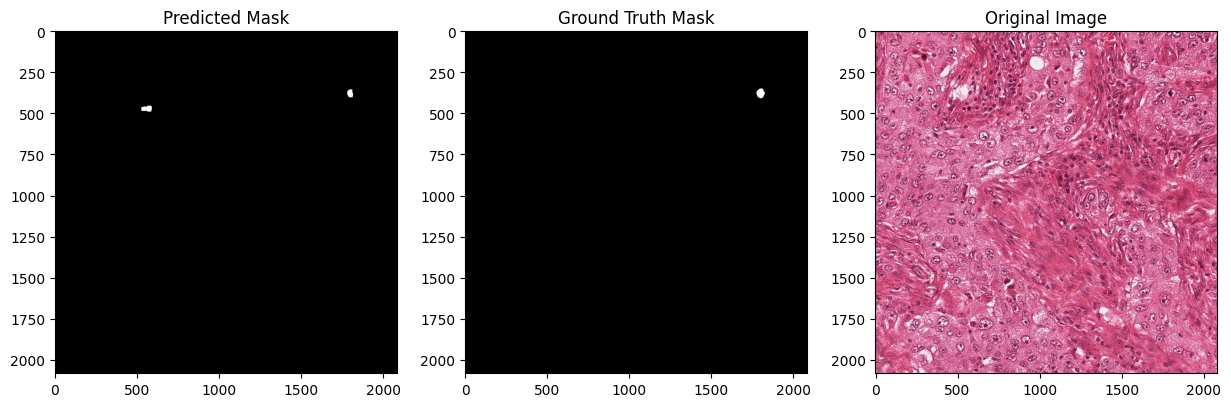

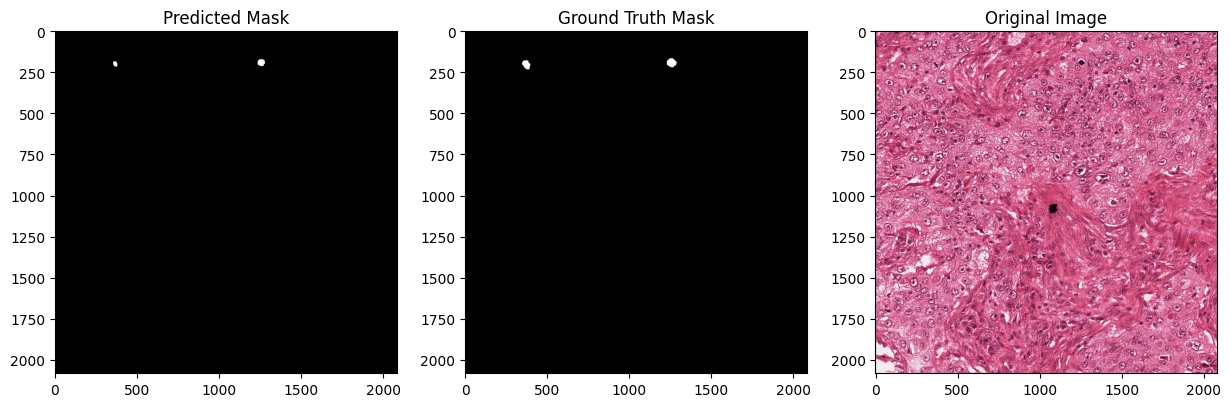

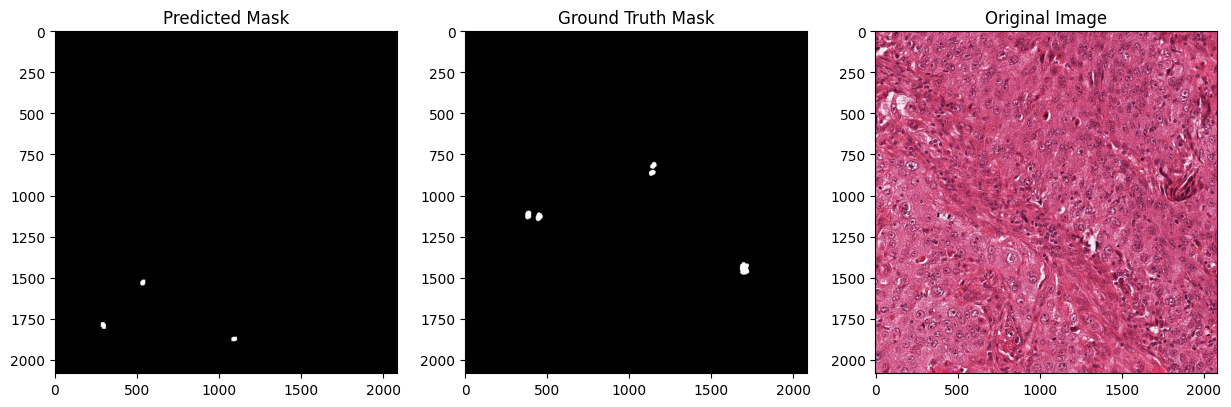

In [ ]:
ious = []

folder_name = "A00_v2"
folder_path = os.path.join(image_folder, folder_name)

def compute_mask_iou(pred_mask, gt_mask):
    """Compute IoU between two binary masks."""
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()
    return intersection / union if union != 0 else 0

for subdir, _, files in os.walk(folder_path):
    for file in files:
        if file.endswith(".bmp"):
            image_name = file
            image_path = os.path.join(subdir, image_name)
            original_image = cv2.imread(image_path)
            segmented_image = preprocess_and_segment(image_path)

            # Load prediction labels from dataframe
            pred_df_image = df_test[df_test["Image"].str.contains(image_name)]
            pred_centroids = pred_df_image[pred_df_image["Predicted_Label"] == 1][["Center_X", "Center_Y"]].values.astype(int)

            # Connected components
            num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(segmented_image)

            # Build predicted pixel mask
            pred_mask = np.zeros_like(segmented_image)
            for i in range(1, num_labels):  # Skip background
                cx, cy = map(int, centroids[i])
                if any(np.linalg.norm(pred_centroids - [cx, cy], axis=1) < 5):  # Match centroids within radius
                    pred_mask[labels == i] = 255

            # Build ground truth pixel mask from CSV using mitosis coordinates
            gt_mask = np.zeros_like(segmented_image)
            csv_path = os.path.join(subdir, image_name.replace(".bmp", ".csv"))
            mitosis_points = []

            if os.path.exists(csv_path):
                with open(csv_path, 'r') as file:
                    for line in file:
                        values = line.strip().split(',')
                        coords = list(zip(map(int, values[::2]), map(int, values[1::2])))
                        mitosis_points.extend(coords)

                for x, y in mitosis_points:
                    if 0 <= x < gt_mask.shape[1] and 0 <= y < gt_mask.shape[0]:
                        cv2.circle(gt_mask, (x, y), 10, 255, -1)  # Ground truth region = white in binary mask

            else:
                print(f"⚠️ CSV not found for: {image_name}")

            # IoU Calculation
            iou = compute_mask_iou(pred_mask > 0, gt_mask > 0)
            ious.append(iou)
            print(f"📏 Pixel-wise IoU for {image_name}: {iou:.4f}")

            # Optional Visualization
            plot_three_side(pred_mask, gt_mask, original_image, title1="Predicted Mask", title2="Ground Truth Mask",title3="Original Image")

# 📊 Summary
mean_iou = np.mean(ious) if ious else 0
print(f"\n✅ Mean Pixel-wise IoU across {len(ious)} images in {folder_name}: {mean_iou:.4f}")
